In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count
import pyspark

print(pyspark.__version__)

3.5.0


In [2]:
# Create a Spark session
spark = SparkSession.builder.appName("GroupCSVData").getOrCreate()


In [3]:
# Path to the CSV file
csv_file_path = "../data/events.csv.gz"

# Read the CSV file into a DataFrame
df_eventos = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df_eventos.show()


+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
|  18|    0|      0|  1|20211001|     4|      90C|           5B0|
|  13|    1|    618|  0|20211001|     9|      7AB|           4CA|
|  16|    1|    172|  0|20211001|     9|      7AB|           4CA|
|   6|    1|    208|  0|20211001|     9|      7AB|           4CA|
|   5|    1|     66|  0|20211001|     9|      7AB|           4CA|
|  18|    1|    135|  0|20211001|     9|      7AB|           4CA|
|  12|    0|      0|  8|20211001|     9|      0A4|           465|
|  21|    

In [4]:
# Mostrar el esquema del DataFrame
df_eventos.printSchema()

root
 |-- hour: integer (nullable = true)
 |-- calls: integer (nullable = true)
 |-- seconds: integer (nullable = true)
 |-- sms: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)



In [5]:
from pyspark.sql.functions import col, sum

nulos_por_columna = df_eventos.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_eventos.columns])
nulos_por_columna.show()


+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
|   0|    0|      0|  0|   0|     0|       18|            15|
+----+-----+-------+---+----+------+---------+--------------+



In [6]:
print("Cantidad total de eventos: ", df_eventos.count())

# Eliminar registros con nulos en "id_source" y "id_destination"
df_eventos = df_eventos.dropna(subset=["id_source", "id_destination"])

print("Cantidad total de eventos sin id_source y id_destination nulos: ", df_eventos.count())

Cantidad total de eventos:  1000000
Cantidad total de eventos sin id_source y id_destination nulos:  999970


In [7]:
# Path to the CSV file
csv_file_path = "../data/free_sms_destinations.csv.gz"

# Read the CSV file into a DataFrame
df_free_ids = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df_free_ids.show(10)

+---+
| id|
+---+
|374|
|D52|
|861|
|5B0|
|4CA|
|465|
|048|
|D5B|
|FD6|
|2D3|
+---+
only showing top 10 rows



In [8]:
# Left join en la columna "id_destination"
joined_df = df_eventos.join(df_free_ids, df_eventos["id_destination"] == df_free_ids["id"], how="left")
joined_df.show()


+----+-----+-------+---+--------+------+---------+--------------+---+
|hour|calls|seconds|sms|    date|region|id_source|id_destination| id|
+----+-----+-------+---+--------+------+---------+--------------+---+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|374|
|  11|    1|      3|  0|20211001|     6|      025|           374|374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|861|
|  18|    0|      0|  1|20211001|     4|      90C|           5B0|5B0|
|  13|    1|    618|  0|20211001|     9|      7AB|           4CA|4CA|
|  16|    1|    172|  0|20211001|     9|      7AB|           4CA|4CA|
|   6|    1|    208|  0|20211001|     9|      7AB|           4CA|4CA|
|   5|    1|     66|  0|20211001|     9|      7AB|           4CA|4CA|
|  18|    1|    135|  0|20211001|     9|      7AB|           4CA|4CA|
|  12|    0|      0|

In [9]:
from pyspark.sql.functions import expr

joined_df = joined_df.withColumn("importe_segun_region", 
                                 expr("CASE " + 
                                      "WHEN id IS NOT NULL THEN 0 " + 
                                      "WHEN REGION BETWEEN 1 and 5 THEN 1.5 " + 
                                      "WHEN REGION BETWEEN 6 and 9 THEN 2 END" ))
# Revisar que se hayan asignado correctamente los importes segun la region
joined_df.selectExpr("region", "case when id is null then 'nulo' when id is not null then 'no nulo' end as id", "importe_segun_region").distinct().orderBy("id", "region").show(100)



+------+-------+--------------------+
|region|     id|importe_segun_region|
+------+-------+--------------------+
|     1|no nulo|                 0.0|
|     2|no nulo|                 0.0|
|     3|no nulo|                 0.0|
|     4|no nulo|                 0.0|
|     5|no nulo|                 0.0|
|     6|no nulo|                 0.0|
|     7|no nulo|                 0.0|
|     8|no nulo|                 0.0|
|     9|no nulo|                 0.0|
|     1|   nulo|                 1.5|
|     2|   nulo|                 1.5|
|     3|   nulo|                 1.5|
|     4|   nulo|                 1.5|
|     5|   nulo|                 1.5|
|     6|   nulo|                 2.0|
|     7|   nulo|                 2.0|
|     8|   nulo|                 2.0|
|     9|   nulo|                 2.0|
+------+-------+--------------------+



In [10]:
# Respuesta punto 1: Calcular el monto total que facturará el proveedor del servicio por envíos de sms.

total = joined_df.agg(sum("importe_segun_region")).collect()[0][0]
print("Monto total a facturar: ", total)

Monto total a facturar:  1696022.5


In [11]:
# Obtener el total de la facturacion por ID
facturacion_df = joined_df.groupBy("id_source").agg(sum("importe_segun_region").alias("monto_a_facurar"))
facturacion_df.show()


+---------+---------------+
|id_source|monto_a_facurar|
+---------+---------------+
|      20E|          420.0|
|      675|          344.0|
|      829|          402.5|
|      1DB|          415.5|
|      F1B|          344.5|
|      B05|          397.5|
|      8FC|          384.0|
|      1EE|          421.0|
|      9AE|          386.0|
|      A23|          367.5|
|      08C|          333.5|
|      6DC|          400.5|
|      13C|          423.5|
|      691|          361.5|
|      467|          338.0|
|      EE0|          413.5|
|      296|          374.5|
|      2C8|          370.0|
|      800|          382.0|
|      5BB|          501.0|
+---------+---------------+
only showing top 20 rows



In [12]:
# Revisar que haya la misma cantidad de IDs unicos en el data set original y IDs con montos a facturar
if facturacion_df.count() == df_eventos.select("id_source").distinct().count():
    print("Cantidad de IDs correcta")
else:
    print("Cantidad de IDs incorrectas")


Cantidad de IDs correcta


In [13]:
from pyspark.sql.functions import md5

facturacion_df = facturacion_df.orderBy("monto_a_facurar", ascending=False).limit(100)
facturacion_df = facturacion_df.select("id_source", md5(col("id_source")).alias("hashed_id"), "monto_a_facurar")

facturacion_df.show(10)

+---------+--------------------+---------------+
|id_source|           hashed_id|monto_a_facurar|
+---------+--------------------+---------------+
|      4D3|911914c7729eedbdf...|        18573.0|
|      76D|bd180b7811395cbce...|        13508.0|
|      07E|14a0660ae2f5d1868...|         4070.0|
|      541|16c222aa19898e505...|         1707.0|
|      B86|bc97b32ee2abb9c18...|         1292.5|
|      3AE|6a57072949dbc409c...|         1026.0|
|      1BD|f5a45e33602ea62f9...|         1023.5|
|      3E0|e9d076deb3451cc49...|         1015.5|
|      D29|1b2e80021b5fc82bf...|          892.0|
|      E6F|159e1f3d6ff0e7c3c...|          714.5|
+---------+--------------------+---------------+
only showing top 10 rows



In [14]:
# Punto 2: Escribir los primeros 100 IDs y sus montos a facturar en parquet comprimidos
facturacion_df.coalesce(1) \
    .write \
    .option("compression", "gzip") \
    .mode("overwrite") \
    .parquet("../data/output")

In [15]:
llamadas_df = df_eventos.groupBy("hour").agg(sum("calls").alias("cantidad_llamadas")).orderBy("hour")
llamadas_df = llamadas_df.withColumnRenamed("hour", "hora")

llamadas_df.show(25)

+----+-----------------+
|hora|cantidad_llamadas|
+----+-----------------+
|   0|             6440|
|   1|             3222|
|   2|             1853|
|   3|             1514|
|   4|             1955|
|   5|             4090|
|   6|             9655|
|   7|            23033|
|   8|            43608|
|   9|            62837|
|  10|            74797|
|  11|            78792|
|  12|            80127|
|  13|            81541|
|  14|            77989|
|  15|            75304|
|  16|            72227|
|  17|            71417|
|  18|            70742|
|  19|            70057|
|  20|            62158|
|  21|            46514|
|  22|            30933|
|  23|            16726|
+----+-----------------+



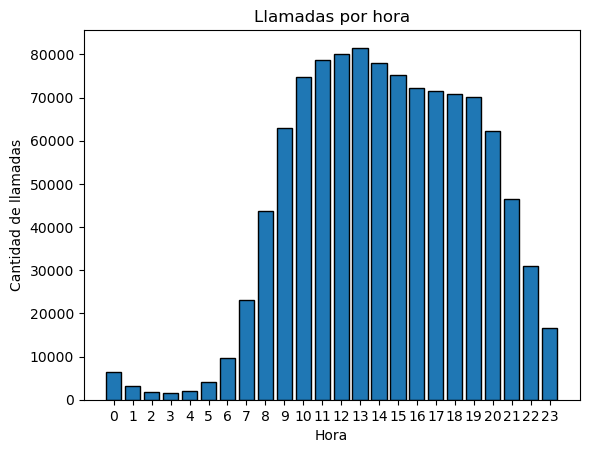

In [16]:
# Punto 3: Graficar un histograma con las llamadas por hora

import matplotlib.pyplot as plt

llamadas_df = df_eventos.groupBy("hour").agg(sum("calls").alias("cantidad_llamadas")).orderBy("hour")
llamadas_df = llamadas_df.withColumnRenamed("hour", "hora")

# Recoger los resultados y prepararlos para graficar
bin_values = [row["hora"] for row in llamadas_df.collect()]
bin_heights = [row["cantidad_llamadas"] for row in llamadas_df.collect()]

# Graficar el histograma
plt.bar(bin_values, bin_heights, edgecolor="black", tick_label=bin_values)
plt.xlabel("Hora")
plt.ylabel("Cantidad de llamadas")
plt.title("Llamadas por hora")
plt.show()
